In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
torch.set_default_dtype(torch.float64) 
#if torch.cuda.is_available():
#    device = 'cuda'
#else:
device = 'cpu'
    
import numpy as np

import ase 
from ase.io import read, write
from ase.units import Hartree

import matplotlib.pyplot as plt

import json  
import chemiscope as cs
import hickle

from mlelec.features.acdc import compute_features_for_target
from mlelec.data.dataset import get_dataloader
from mlelec.data.dataset import MoleculeDataset
from mlelec.data.dataset import MLDataset
from mlelec.models.linear import LinearTargetModel
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
import mlelec.metrics as mlmetrics
from mlelec.utils.learning_utils import compute_batch_dipole_moment, compute_dipole_moment_from_mf, instantiate_mf, compute_dipole_moment

import os
os.environ["PYSCFAD_BACKEND"] = "torch"

from pyscf import gto
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf

from IPython.utils import io

import warnings
from pathlib import Path

Using PyTorch backend.


/home/pegolo/micromamba/envs/tut/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
import numpy as np
from pyscf import gto, dft
from ase.io import read

MOL = "pentacene"
LOT = "b3lypg"
BAS = "sto3g"
NFR = 1000


def get_geom(positions, numbers):
    atom = ""
    for n, p in zip(numbers, positions):
        atom += f"{n:d}   {p[0]:.6f}   {p[1]:.6f}   {p[2]:.6f}\n"
    atom = atom[:-1]
    return atom


def get_output(mf):
    fock = mf.get_fock()
    ovlp = mf.get_ovlp()
    dm = mf.make_rdm1()
    pop, chg = mf.mulliken_pop()
    ao_labels = mf.mol.ao_labels()
    dip_moment = mf.dip_moment()
    energy_elec = mf.energy_elec()
    energy_tot = mf.energy_tot()
    converged = mf.converged

    out = dict(
        fock=fock,
        ovlp=ovlp,
        dm=dm,
        pop=pop,
        chg=chg,
        ao_labels=ao_labels,
        dip_moment=dip_moment,
        energy_elec=energy_elec,
        energy_tot=energy_tot,
        converged=converged,
    )

    return out


def single_point(positions, numbers, out_idx, dm=None):
    mol = gto.M(
        atom=get_geom(positions, numbers),
        basis=BAS,
        symmetry=False,
        charge=0,
        spin=0,
        verbose=5,
        cart=False,
        output=f"{out_idx:05d}.pylog",
    )
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = LOT
    mf.conv_tol = 1e-10
    # mf.max_cycle = 400
    # mf.conv_tol_grad = 1e-10
    # mf.diis_space = 12

    grids = dft.Grids(mol)
    grids.atom_grid = (99, 590)
    grids.build()
    mf.grids = grids

    if dm is None:
        mf.kernel()
    else:
        mf.kernel(dm)

    print("Converged:", mf.converged)

    out = get_output(mf)

    np.savez(
        f"{out_idx:05d}.npz",
        **out,
    )

In [3]:
output = np.load("/home/saade/mlelec/tutorials/data/pentacene/sto-3g/00000.npz")

In [4]:
output['fock']

array([[-1.00271409e+01, -2.73906041e+00, -3.50767412e-04, ...,
         4.75793990e-09,  8.12629712e-08, -2.34238048e-09],
       [-2.73906041e+00, -1.38152499e+00, -1.26098259e-02, ...,
         1.77096144e-08, -9.98640511e-07, -6.14584140e-07],
       [-3.50767412e-04, -1.26098259e-02, -1.30623835e-01, ...,
         5.72759996e-07, -9.46985381e-06,  5.54036601e-06],
       ...,
       [ 4.75793990e-09,  1.77096144e-08,  5.72759996e-07, ...,
        -5.37659220e-01, -1.50262062e-03, -1.11557506e-01],
       [ 8.12629712e-08, -9.98640511e-07, -9.46985381e-06, ...,
        -1.50262062e-03, -2.18713290e-01, -4.80805287e-02],
       [-2.34238048e-09, -6.14584140e-07,  5.54036601e-06, ...,
        -1.11557506e-01, -4.80805287e-02, -5.51650934e-01]])

In [5]:
frame_pentacene = ase.io.read('/home/saade/mlelec/tutorials/data/pentacene/Pentacene.xyz',":")

In [6]:
frame_pentacene[0].info

{'0': True, '1': True}

In [7]:
num_configs = 100
random_pentacene_config = []
for i in range(num_configs):
    perturbed_positions = frame_pentacene[0].positions + np.random.normal(scale = 0.1, size = frame_pentacene[0].positions.shape)

    perturbed_pentacene = frame_pentacene[0].copy()
    perturbed_pentacene.positions = perturbed_positions
    random_pentacene_config.append(perturbed_pentacene)

write(f'pentacene_config_{num_configs}.xyz', random_pentacene_config)

frames = read(f'pentacene_config_{num_configs}.xyz', index = ':')
cs.show(frames, mode = 'structure', environments=cs.all_atomic_environments(frames, cutoff=15))

<StructureWidget(meta={'name': ' '}, structures=[{'size': 36, 'names': ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'…

In [8]:
#for idx, structure in enumerate(random_pentacene_config):
    #single_point(structure.positions, structure.numbers, idx, dm=None)

In [9]:
output = np.load("/home/saade/mlelec/tutorials/data/pentacene/sto-3g/00000.npz")

In [10]:
output['fock']

array([[-1.00271409e+01, -2.73906041e+00, -3.50767412e-04, ...,
         4.75793990e-09,  8.12629712e-08, -2.34238048e-09],
       [-2.73906041e+00, -1.38152499e+00, -1.26098259e-02, ...,
         1.77096144e-08, -9.98640511e-07, -6.14584140e-07],
       [-3.50767412e-04, -1.26098259e-02, -1.30623835e-01, ...,
         5.72759996e-07, -9.46985381e-06,  5.54036601e-06],
       ...,
       [ 4.75793990e-09,  1.77096144e-08,  5.72759996e-07, ...,
        -5.37659220e-01, -1.50262062e-03, -1.11557506e-01],
       [ 8.12629712e-08, -9.98640511e-07, -9.46985381e-06, ...,
        -1.50262062e-03, -2.18713290e-01, -4.80805287e-02],
       [-2.34238048e-09, -6.14584140e-07,  5.54036601e-06, ...,
        -1.11557506e-01, -4.80805287e-02, -5.51650934e-01]])

In [4]:
mu = hickle.load('data/pentacene/sto-3g/dipole_moment.hkl')

In [8]:
for frame, dipole in zip(frames, mu):
    frame.info['mu'] = dipole

In [9]:
orb_name = {'1s': [1,0,0], '2s': [2, 0, 0], '2px': [2, 1, 1], '2py': [2, 1, -1], '2pz': [2, 1, 0]}
atomic_number = {'C': 6, 'H': 1}

In [10]:
orbitals = {atomic_number['C']: [orb_name[k] for k in ['1s', '2s', '2px', '2py', '2pz']], atomic_number['H']: [orb_name['1s']]}

In [6]:
load_precomputed = True
molecules_slice = slice(0, 1)

In [7]:
frames = read('data/pentacene/pentacene_config_100.xyz', index = molecules_slice)

In [11]:
if not load_precomputed:
    
    molecule_data = MoleculeDataset(mol_name = "pentacene",
                                    use_precomputed = False,
                                    path = "./data/pentacene", 
                                    aux_path = "./data/pentacene/sto-3g", 
                                    frame_slice = molecules_slice,
                                    device = device,
                                    aux = ["overlap", "orbitals"],
                                    target = ["fock", "dipole_moment"])
                            
else:
    focks = hickle.load('./data/pentacene/sto-3g/fock.hkl')[molecules_slice]
    overlaps = hickle.load('./data/pentacene/sto-3g/ovlp.hkl')[molecules_slice]
    #orbitals = hickle.load('./data/pentacene/sto-3g/orbs.hkl')

    molecule_data = MoleculeDataset(
        mol_name = "pentacene",
        frames = frames[molecules_slice],
        frame_slice = molecules_slice, 
        device = device,
        aux = ["overlap", "orbitals"],
        target = ["fock", "dipole_moment"],
        target_data = {"fock": torch.from_numpy(focks), "dipole_moment": torch.from_numpy(np.array([frame.info['mu'] for frame in frames[molecules_slice]]))},
        aux_data = {"overlap": torch.from_numpy(overlaps), "orbitals": orbitals})

In [12]:
seed = 1
train_frac = 1 #0.7
val_frac = 0 #0.2
test_frac = 0 #0.1

In [13]:
ml_data = MLDataset(
    molecule_data = molecule_data,
    device = device,
    model_strategy = "coupled", 
    shuffle = True,
    shuffle_seed = seed,
)  

ml_data._split_indices(train_frac = train_frac, val_frac = val_frac, test_frac = test_frac)

In [32]:
from ase.visualize import view
view(frames)

<Popen: returncode: None args: ['/home/saade/miniconda3/envs/tutorial/bin/py...>

In [38]:
#Hyperparameters of the features

hypers = {
            "cutoff": 4.0,
            "max_radial" : 8,
            "max_angular": 6,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }
hypers_pair = {
            "cutoff": 10.0,
            "max_radial" : 8,
            "max_angular": 6,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }

if hypers is None:
    ml_data._set_features(compute_features_for_target(ml_data, device = "cpu"))
else:
    ml_data._set_features(compute_features_for_target(ml_data, device = device, hypers = hypers, hypers_pair = hypers_pair))

In [39]:
batch_size = 4
train_dl, val_dl, test_dl = get_dataloader(ml_data, batch_size = batch_size, model_return = "blocks")

Model

In [40]:
model = LinearTargetModel(dataset = ml_data, nlayers = 3, nhidden = 16, bias = True, device = device)

In [29]:
np.max(frames[0].get_all_distances())

14.62364872892528

Training

In [41]:
pred_ridges, ridges  = model.fit_ridge_analytical(set_bias=False)

In [42]:
# We compute the loss over individual blocks
block_losses = {}
for k,b in ml_data.target_train.items():
    block_losses[tuple(k.values)] = torch.linalg.norm(b.values - pred_ridges.block(k).values)**2
loss_ = sum(block_losses.values()) # sum of squares losses of all the blocks 


# Get errors in eV from here 
normalizing_factor = 22*5+14 # TOFIX frames[0].get_global_number_of_atoms()*ml_data.molecule_data.basis. per species 
print(f"Training Loss {np.sqrt(loss_/normalizing_factor) * Hartree*1000:.2f} meV")

Training Loss 41.88 meV


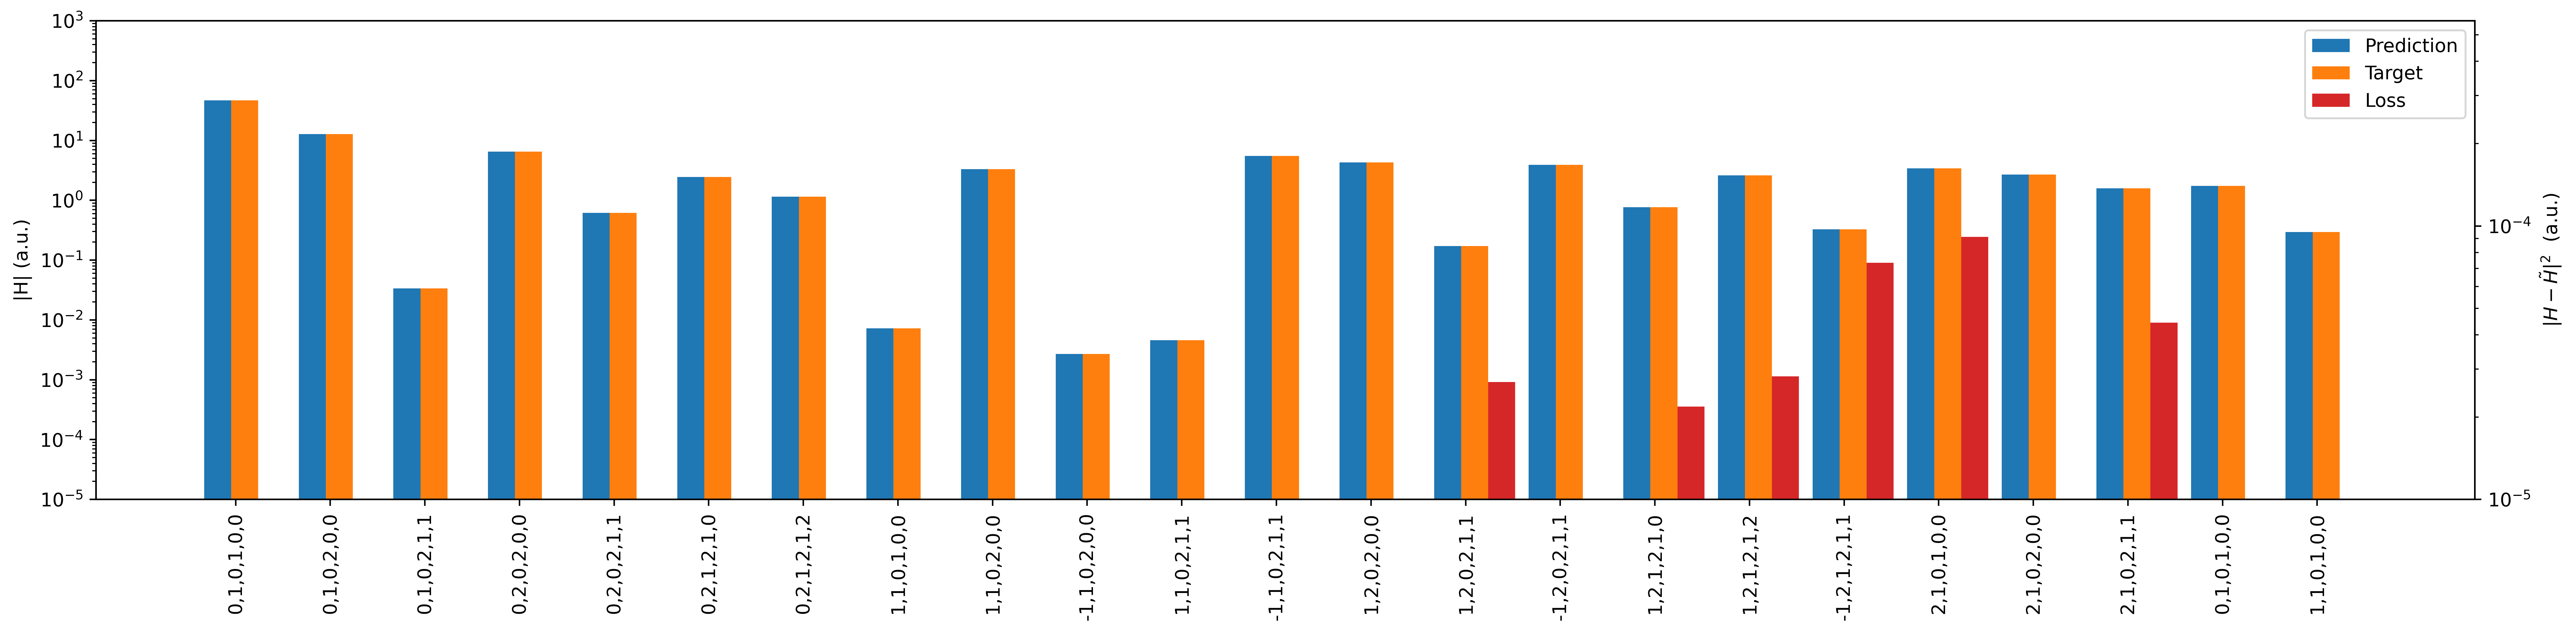

In [43]:
from mlelec.utils.plot_utils import plot_block_errors
fig, ax, ax_loss = plot_block_errors(ml_data.target_train, pred_ridges, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

0.0033072835455533207


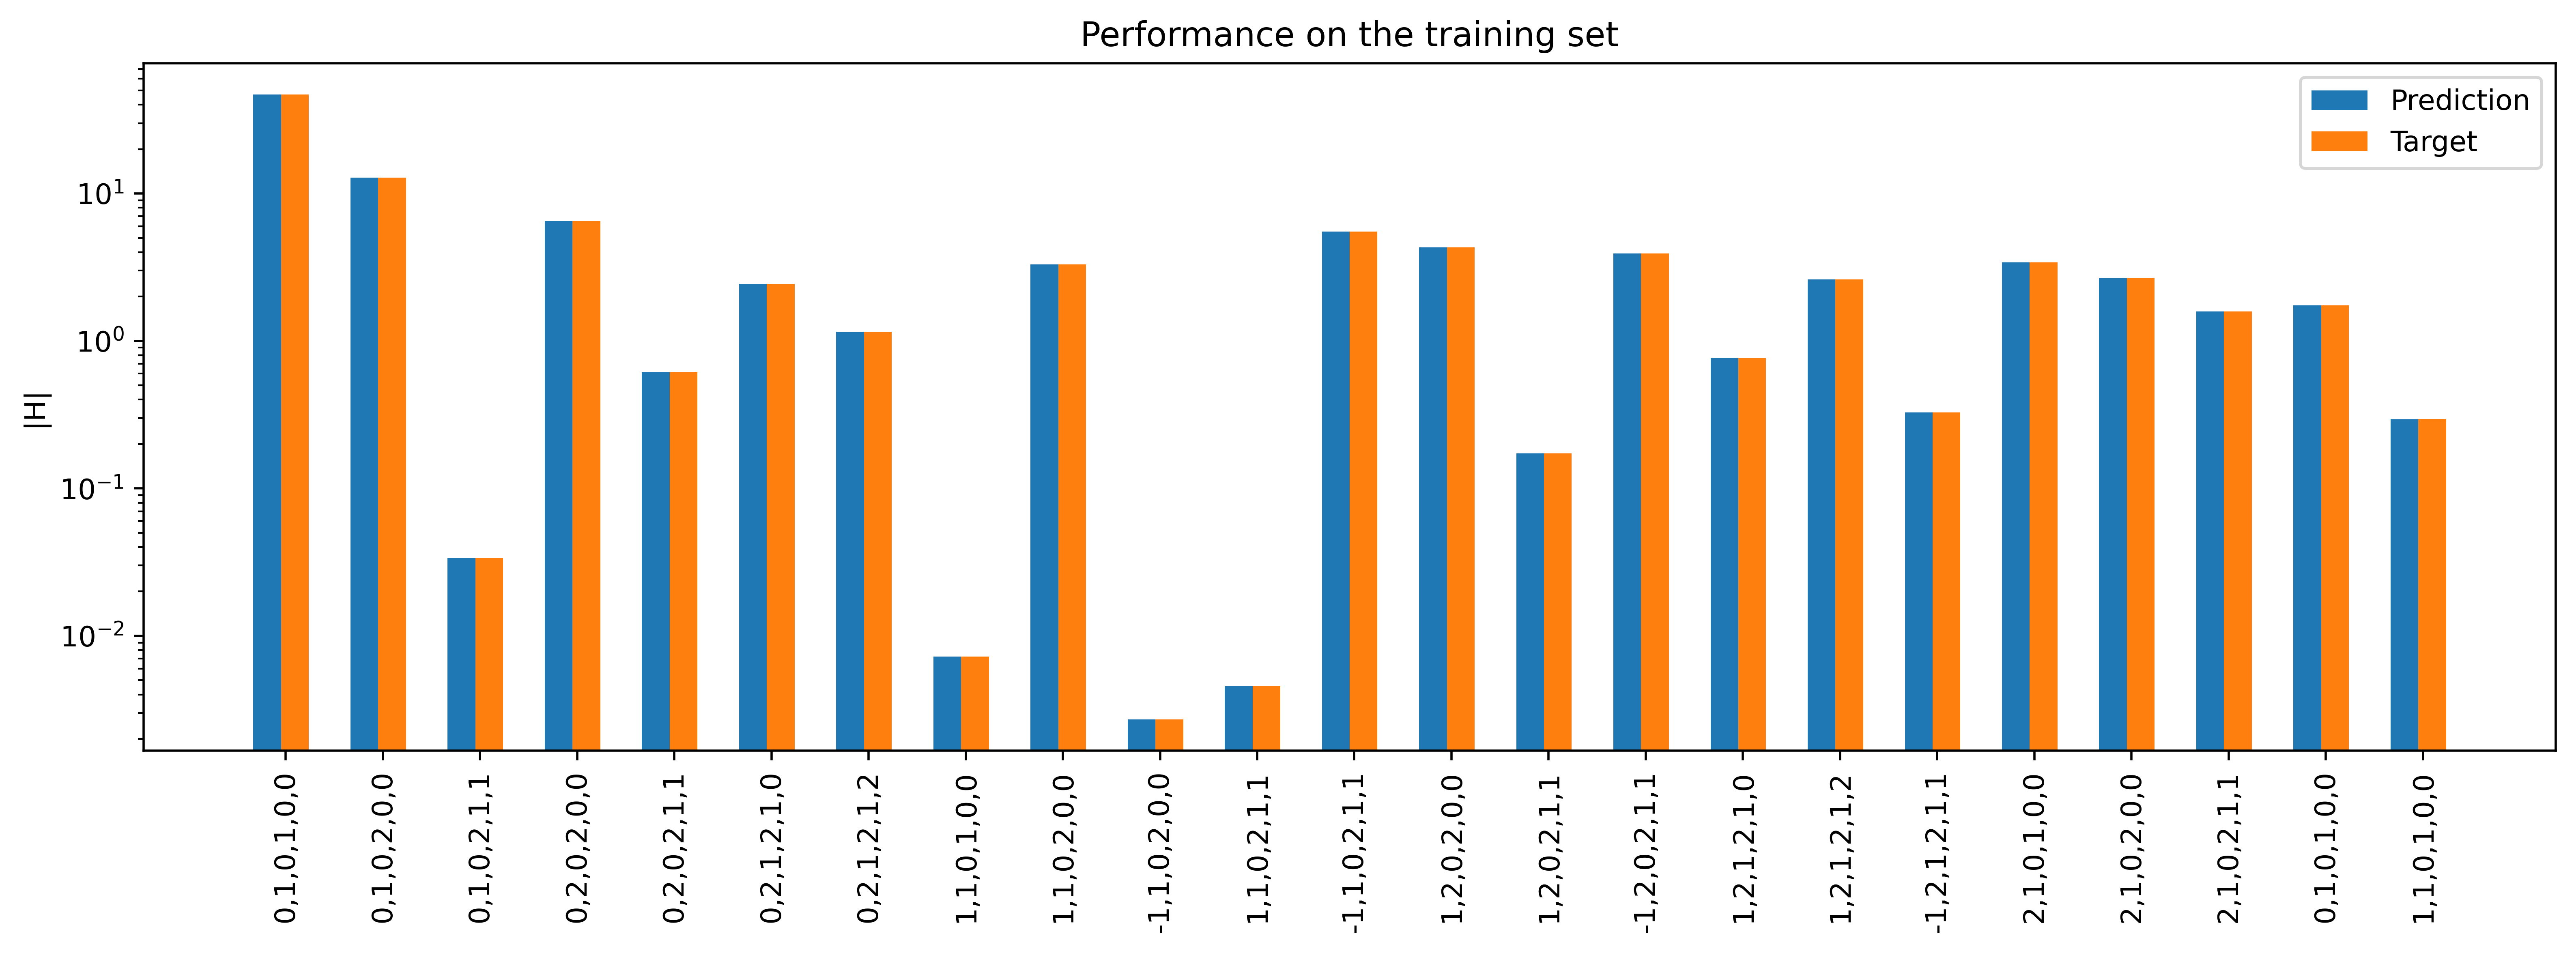

In [33]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 500
x=[','.join([str(lbl[i]) for i in [0,2,3,5,6,7]]) for lbl in ml_data.target.blocks.keys.values.tolist()]
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))
# ax_loss = ax.twinx()
# s = (0,0,0)
prediction_ = np.array([torch.linalg.norm(b.values) for b in pred_ridges])
target_ = np.array([torch.linalg.norm(b.values) for b in ml_data.target_train])
loss_ = np.array([torch.linalg.norm(b.values-b1.values)**2 for b,b1 in zip(ml_data.target_train,pred_ridges)])
print(np.sum(loss_))

loss_blocks = list(block_losses.values())

x_ = 3.5*np.arange(len(loss_blocks))

labels = []
handles = []
pl = ax.bar(x_, prediction_, label = 'pred', width = 1, color = 'tab:blue');
handles.append(pl)
labels.append('Prediction')
pl = ax.bar(x_+1, target_, alpha = 1, label = 'target', width = 1, color = 'tab:orange');
handles.append(pl)
labels.append('Target')

# pl = ax_loss.bar(x_+2, loss_, alpha = 1, label = 'target', width = 1, color = 'tab:red');
# handles.append(pl)
# labels.append('Loss')

# ax.set_ylim(1e-7, 1000)
ax.set_xticks(3.5*np.arange(len(loss_blocks))+3.5/3-0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(handles, labels, loc = 'best')
ax.set_ylabel('|H|')
# ax_loss.set_ylabel('Loss')
# ax_loss.set_yscale('log')
# # ax_loss.set_ylim(1e-7)
ax.set_yscale('log')
ax.set_title('Performance on the training set')
fig.tight_layout()